# **PREDIZIONE DI HOTEL-ID PER LA PREVENZIONE DEL TRAFFICO DI UMANI (FGVC9 2022) - Notebook di inferenza**

**Deep Learning 2022/2023**

**Michele Ferro 1000037665**

# 1 - Caricamento del set di test e di training

In [1]:
import os
import albumentations as A
import albumentations.pytorch as APT
from PIL import Image

/home/michele/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import numpy as np

In [3]:
dataset_path = os.path.join('/run/media/michele/Archivio/DL_project/hotel-id-to-combat-human-trafficking-2022-fgvc9/')

train_path = os.path.join(dataset_path, 'train_images')
test_path = os.path.join(dataset_path, 'test_images')
val_path = os.path.join(dataset_path, 'val_images')

In [4]:
import albumentations as A
import albumentations.pytorch as APT

IMG_SIZE = 128

occlusion_transform = A.CoarseDropout(p=1, max_holes=1, min_height=IMG_SIZE//4, max_height=IMG_SIZE//2,
                                      min_width=IMG_SIZE//4, max_width=IMG_SIZE//2, fill_value=(255, 0, 0))

# transform used for the obtained training set
train_transform = A.Compose([A.HorizontalFlip(p=0.75),
                            A.VerticalFlip(p=0.25),
                            A.ShiftScaleRotate(p=0.5),
                            A.OpticalDistortion(p=0.25),
                            A.Perspective(p=0.25),
                            A.CoarseDropout(p=0.5, min_holes=1, max_holes=6, 
                                            min_height=IMG_SIZE//16, max_height=IMG_SIZE//4,
                                            min_width=IMG_SIZE//16, max_width=IMG_SIZE//4),
                            occlusion_transform,
                            A.Resize(IMG_SIZE, IMG_SIZE),
                            A.RandomBrightnessContrast(p=0.75),
                            A.ToFloat(),
                            APT.transforms.ToTensorV2()])

# transform used for the validation/test set
val_transform = A.Compose([occlusion_transform,
                            A.Resize(IMG_SIZE, IMG_SIZE),
                            A.ToFloat(),
                            APT.transforms.ToTensorV2()])

In [5]:
class HotelDataset:
    def __init__(self, data, transform=None, data_path=train_path, train_val=True):
        self.data = data
        self.transform = transform
        self.data_path = data_path
        self.train_val = train_val

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        record = self.data.iloc[idx]

        if self.train_val:
            image_path = os.path.join(self.data_path,str(record['hotel_id']),record['image_id'])
            label = record['hotel_id']
        else:
            image_path = os.path.join(self.data_path,record['image_id'])
        
        image = np.array(Image.open(image_path)).astype(np.uint8)

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        
        if self.train_val:
            return image, label
        else:
            return image

# 2 - Definizione del modello

In [8]:
import torch
import timm
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torch.optim import SGD
import matplotlib.pyplot as plt
import torchvision

import numpy as np

import pytorch_lightning as pl

## 2.1 EfficientNet-B0 - Classification

In [ ]:
class EfficientNet(pl.LightningModule):
    def __init__(self, n_classes, lr=0.01, momentum=0.99):
        super(EfficientNet, self).__init__()
        self.save_hyperparameters()

        self.network = timm.create_model('efficientnet_b0', num_classes=n_classes, pretrained=True)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.network(x)

        return x

    def configure_optimizers(self):
        optimizer = SGD(self.parameters(), self.hparams.lr, momentum=self.hparams.momentum)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        output = self.forward(x)
        loss = self.criterion(output, y)
        self.log('train/loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        output = self.forward(x)
        loss = self.criterion(output, y)

        acc = accuracy_score(y.cpu(), output.cpu().topk(1).indices)

        self.log('val/loss', loss)

        return {
            'predictions': output.cpu().topk(1).indices,
            'labels': y.cpu()
        }

    def validation_epoch_end(self, outputs):
        predictions = np.concatenate([o['predictions'] for o in outputs])
        labels = np.concatenate([o['labels'] for o in outputs])

        acc = accuracy_score(labels, predictions)

        self.log('val/accuracy', acc)

## 2.2 - HotelPredictionNetwork v1 - Classification

In [7]:
class HotelPredictionNetworkv1(pl.LightningModule):
    def __init__(self, n_classes, embedding_size, extractor_name='efficientnet_b0', lr=0.01, momentum=0.99):
        super(HotelPredictionNetworkv1, self).__init__()
        self.save_hyperparameters()

        self.extractor = timm.create_model(extractor_name, num_classes=n_classes, pretrained=True)
        in_features = self.extractor.get_classifier().in_features

        self.extractor.classifier = nn.Identity()

        self.embedding = nn.Linear(in_features, embedding_size)
        self.classifier = nn.Linear(embedding_size, n_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.extractor(x)
        x = x.view(x.shape[0], -1)
        x = self.embedding(x)
        x = self.classifier(x)

        return x

    def configure_optimizers(self):
        optimizer = SGD(self.parameters(), self.hparams.lr, momentum=self.hparams.momentum)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        output = self.forward(x)
        loss = self.criterion(output, y)
        self.log('train/loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        output = self.forward(x)
        loss = self.criterion(output, y)

        acc = accuracy_score(y.cpu(), output.cpu().topk(1).indices)

        self.log('val/loss', loss)

        return {
            'predictions': output.cpu().topk(1).indices,
            'labels': y.cpu()
        }

    def validation_epoch_end(self, outputs):
        predictions = np.concatenate([o['predictions'] for o in outputs])
        labels = np.concatenate([o['labels'] for o in outputs])

        acc = accuracy_score(labels, predictions)

        self.log('val/accuracy', acc)

## 2.3 - HotelPredictionNetwork v2 - Metric Learning

In [9]:
from torch.nn import functional as F

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, m=2):
        super(ContrastiveLoss, self).__init__()
        self.m = m

    def forward(self, phi_i, phi_j, l_ij):
        l_ij = l_ij.float()
        d = F.pairwise_distance(phi_i, phi_j)
        l = (0.5 * (1 - l_ij) * torch.pow(d, 2)) + (0.5 * l_ij * torch.pow(torch.clamp(self.m - d, min=0),2))

        return l.mean()

In [10]:
class HotelPredictionNetworkv2(pl.LightningModule):
    def __init__(self, extractor_name='efficientnet_b0', lr=0.01, momentum=0.99, margin=2):
        super(HotelPredictionNetworkv2, self).__init__()
        self.save_hyperparameters()

        self.embedding = timm.create_model(extractor_name, num_classes=1, pretrained=True)
        self.embedding.classifier = nn.Identity()

        self.criterion = ContrastiveLoss(margin)

    def forward(self, x):
        return self.embedding(x)

    def configure_optimizers(self):
        optimizer = SGD(self.embedding.parameters(), self.hparams.lr, momentum=self.hparams.momentum)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        I_i, I_j, l_ij, *_ = train_batch

        phi_i = self.embedding(I_i)
        phi_j = self.embedding(I_j)

        loss = self.criterion(phi_i, phi_j, l_ij)

        self.log('train/loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        I_i, I_j, l_ij, *_ = val_batch

        phi_i = self.embedding(I_i)
        phi_j = self.embedding(I_j)

        loss = self.criterion(phi_i, phi_j, l_ij)

        self.log('val/loss', loss)

        if batch_idx==0:
            self.logger.experiment.add_embedding(phi_i, val_batch[3], I_i, global_step=self.global_step)

## 2.4 HotelPredictionNetwork v3 - Classificazione

In [ ]:
class HotelPredictionNetworkv3(pl.LightningModule):
    def __init__(self, n_classes, embedding_size, lr=0.01, momentum=0.99):
        super(HotelPredictionNetworkv3, self).__init__()
        self.save_hyperparameters()

        self.backbone = HotelPredictionNetworkv2.load_from_checkpoint('metric_logs/siamese_hotel_id/version_0/checkpoints/epoch=4-step=2795.ckpt')
        model = list(self.backbone.children())[-2]
        out_layer = list(model.children())[-4]
        out_features = out_layer.out_channels

        self.embedding = nn.Linear(out_features, embedding_size)
        self.classifier = nn.Linear(embedding_size, n_classes)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.backbone(x)
        x = self.embedding(x)
        x = self.classifier(x)

        return x

    def configure_optimizers(self):
        optimizer = SGD(self.parameters(), self.hparams.lr, momentum=self.hparams.momentum)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        output = self.forward(x)
        loss = self.criterion(output, y)
        self.log('train/loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        output = self.forward(x)
        loss = self.criterion(output, y)

        acc = accuracy_score(y.cpu(), output.cpu().topk(1).indices)

        self.log('val/loss', loss)

        return {
            'predictions': output.cpu().topk(1).indices,
            'labels': y.cpu()
        }

    def validation_epoch_end(self, outputs):
        predictions = np.concatenate([o['predictions'] for o in outputs])
        labels = np.concatenate([o['labels'] for o in outputs])

        acc = accuracy_score(labels, predictions)

        self.log('val/accuracy', acc)

# 3 - Caricamento dei modelli da checkpoint

In [11]:
import pandas as pd

df_train = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
df_val = pd.read_csv(os.path.join(dataset_path, 'val.csv'))
df_test = pd.read_csv(os.path.join(dataset_path, 'test.csv'))

## 3.1 - Classificatore `EfficientNet`

Viene caricato il classificatore pre-addestrato.

In [ ]:
n_classes_train = df_train['hotel_id'].max()
n_classes_val = df_val['hotel_id'].max()

n_classes = max(n_classes_train, n_classes_val) + 1

model = EfficientNet(n_classes)

## 3.2 - Classificatore `HotelPredictionNetworkv1`

Viene caricato il classificatore addestrato nel notebook di training.

In [10]:
n_classes_train = df_train['hotel_id'].max()
n_classes_val = df_val['hotel_id'].max()

n_classes = max(n_classes_train, n_classes_val) + 1

model = HotelPredictionNetworkv1.load_from_checkpoint('classification_logs/class_hotel_id/version_2/checkpoints/epoch=4-step=2795.ckpt', n_classes=n_classes, embedding_size=128)

## 3.3 - Rete siamese `HotelPredictionNetworkv2`

Viene caricata la rete siamese addestrata nel notebook di training.

In [14]:
model = HotelPredictionNetworkv2.load_from_checkpoint('metric_logs/siamese_hotel_id/version_0/checkpoints/epoch=4-step=2795.ckpt', n_classes=1)

## 3.4 - Classificatore `HotelPredictionNetworkv3`

Viene caricato il classificatore addestrato nel notebook di training.

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger

n_classes_train = df_train['hotel_id'].max()
n_classes_val = df_val['hotel_id'].max()

n_classes = max(n_classes_train, n_classes_val) + 1

model = HotelPredictionNetworkv3.load_from_checkpoint('classification_logs/siamesewclass_hotel_id/version_0/checkpoints/epoch=4-step=2795.ckpt')

# 4 - Inferenze

## 4.1 Classificazione

La seguente procedura può essere utilizzata per effettuare un'inferenza su un DataLoader di test.

In [ ]:
def predict(model, loader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    model.to(device)
    preds = []

    for batch in loader:
        for im in batch:
            x = im.to(device)
            x = x.unsqueeze(0)
            output = model(x)
            output = output.detach().to('cpu').numpy()
            _, pred = output.max(dim=1)
            preds.append(pred)

    return np.concatenate(preds)

La seguente procedura può invece essere utilizzata per effettuare un'inferenza su un'immagine caricata da disco.

In [11]:
from PIL import Image

def predict_image(model, image):
    image = Image.open(image)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    model.to(device)
    convert_tensor = transforms.ToTensor()
    x = convert_tensor(image)
    
    x = x.to(device)
    x = x.unsqueeze(0)

    output = model(x)
    _, pred = output.max(dim=1)

    print('Predicted class:', pred[0].item())
    plt.imshow(image)

Predicted class: 36539


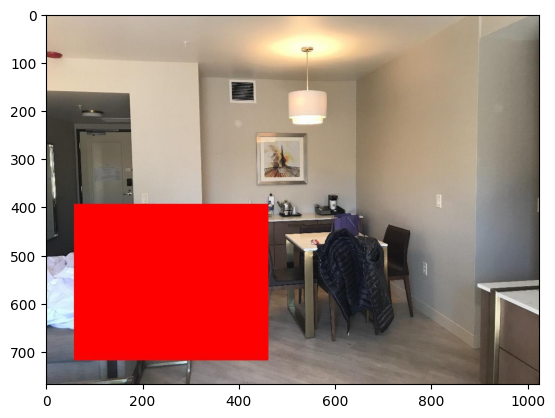

In [12]:
im = os.path.join(test_path, 'abc.jpg')

predict_image(model, im)

## 4.2 - Estrazione

La seguente cella definisce una serie di procedure utilizzate per effettuare un'inferenza su un DataLoader di test.

In [17]:
from sklearn.metrics import euclidean_distances
from tqdm import tqdm

def find_matches(query, base_embeds, base_targets, n_matches=5):
    distance_df = pd.DataFrame(index=np.arange(len(base_targets)), data={"hotel_id": base_targets})
    # calculate euclidean distance of query embeds to all base embeds
    distance_df["distance"] = euclidean_distances([query], list(base_embeds))[0]
    # sort by distance and hotel_id
    distance_df = distance_df.sort_values(by=["distance", "hotel_id"], ascending=False).reset_index(drop=True)
    # return first 5 different hotel_id codes
    return distance_df["hotel_id"].unique()[:n_matches]

def extract_representations(model, loader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    model.to(device)
    representations = []

    for batch in loader:
        for im in batch:
            x = im.to(device)
            x = x.unsqueeze(0)
            rep = model(x)
            rep = rep.detach().to('cpu').numpy()
            representations.append(rep)

    return np.concatenate(representations)

def predict(base_embeddings_df, test_loader, model):
    test_embeds = extract_representations(model, test_loader)
    
    preds = []
    for query_embeds in tqdm(test_embeds, desc="Similarity - match finding"):
        tmp = find_matches(query_embeds, 
                           base_embeddings_df["representation"].values, 
                           base_embeddings_df["hotel_id"].values)
        preds.extend([tmp])
        
    return preds

In [18]:
base_embeddings = pd.read_pickle(os.path.join(dataset_path, 'train_image-embeddings.pkl'))

base_embeddings.head()

,image_id,hotel_id,representation
0,000003767.jpg,100055,"[-0.23942466, -0.20735869, -0.22223592, -0.208..."
1,000003768.jpg,100055,"[-0.23135966, -0.19363037, -0.20756839, -0.190..."
2,000019601.jpg,10010,"[-0.22385257, -0.19876081, -0.21029243, -0.202..."
3,000019602.jpg,10010,"[-0.21756901, -0.19270661, -0.202687, -0.19265..."
4,000019605.jpg,10010,"[-0.23554295, -0.2028898, -0.21720469, -0.2073..."


In [29]:
hotel_test = HotelDataset(df_test, val_transform, test_path, train_val=False)
hotel_test_loader = DataLoader(hotel_test, batch_size=64, num_workers=8)

In [30]:
preds = predict(base_embeddings, hotel_test_loader, siamese_hotel_task)


Similarity - match finding: 100%|██████████| 8942/8942 [46:35<00:00,  3.20it/s]   


In [31]:
df_test["hotel_id"] = [str(list(l)).strip("[]").replace(",", "") for l in preds]

df_test.head()

,image_id,hotel_id
0,0.jpg,12016 309982 300431 93037 310252
1,1.jpg,12016 309982 1201 80365 87937
2,10.jpg,12016 309982 1201 80365 87937
3,100.jpg,12016 309982 1201 80365 87937
4,1000.jpg,12016 309982 1201 80365 87937


In [32]:
df_test.to_csv(os.path.join(dataset_path, 'preds.csv'))


La seguente cella definisce invece una serie di procedure utilizzate per effettuare un'inferenza su un'immagine da disco.

In [20]:
from sklearn.metrics import euclidean_distances
from tqdm import tqdm

def find_matches(query, base_embeds, base_targets, n_matches=5):
    distance_df = pd.DataFrame(index=np.arange(len(base_targets)), data={"hotel_id": base_targets})
    # calculate euclidean distance of query embeds to all base embeds
    distance_df["distance"] = euclidean_distances(query, list(base_embeds))[0]
    # sort by distance and hotel_id
    distance_df = distance_df.sort_values(by=["distance", "hotel_id"], ascending=False).reset_index(drop=True)
    # return first 5 different hotel_id codes
    return distance_df["hotel_id"].unique()[:n_matches]

def extract_image_representation(model, image):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    model.to(device)
    convert_tensor = transforms.ToTensor()

    x = convert_tensor(image)
    x = x.to(device)
    x = x.unsqueeze(0)
    rep = model(x)
    rep = rep.detach().to('cpu').numpy()

    return rep

def predict_image(base_embeddings_df, image, model):
    im = Image.open(image)
    image_embeds = extract_image_representation(model, im)
    
    preds = []
    tmp = find_matches(image_embeds, 
                        base_embeddings_df["representation"].values, 
                        base_embeddings_df["hotel_id"].values)
    preds.extend([tmp])
        
    print('Most similar 5 classes:', np.concatenate(preds))
    plt.imshow(im)


Most similar 5 classes: [ 12016 309982 300431  93037  40578]


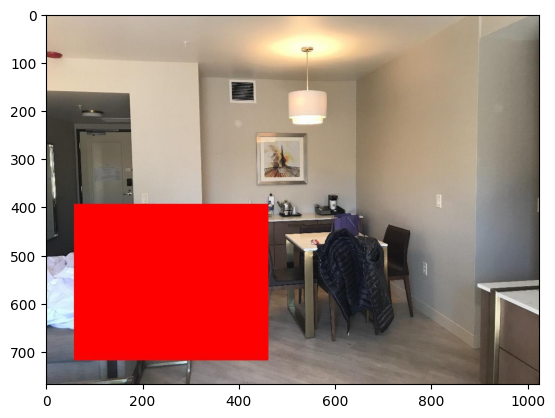

In [22]:
im = os.path.join(test_path, 'abc.jpg')

predict_image(base_embeddings, im, model)